In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
df=pd.read_csv(r'C:\Users\rajesh\Desktop\Zassignment\nyc-rolling-sales.csv')

In [3]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
del df['EASE-MENT']

del df['Unnamed: 0']

del df['SALE DATE']

In [5]:
sum(df.duplicated(df.columns))

1358

In [6]:
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83190 non-null  int64 
 1   NEIGHBORHOOD                    83190 non-null  object
 2   BUILDING CLASS CATEGORY         83190 non-null  object
 3   TAX CLASS AT PRESENT            83190 non-null  object
 4   BLOCK                           83190 non-null  int64 
 5   LOT                             83190 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83190 non-null  object
 7   ADDRESS                         83190 non-null  object
 8   APARTMENT NUMBER                83190 non-null  object
 9   ZIP CODE                        83190 non-null  int64 
 10  RESIDENTIAL UNITS               83190 non-null  int64 
 11  COMMERCIAL UNITS                83190 non-null  int64 
 12  TOTAL UNITS                     83190 non-null

In [8]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [9]:
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [10]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [11]:
miss=miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


In [12]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())


In [13]:
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [14]:
test = test.drop(columns='SALE PRICE')

<AxesSubplot:>

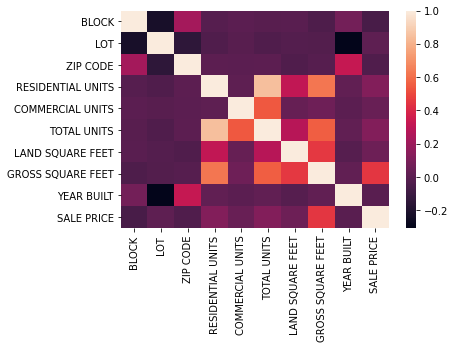

In [15]:
corr = data.corr()
sns.heatmap(corr)

In [16]:
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [17]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,6.928100e+04,6.928100e+04,69281.000000,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.643061e+03,3.640300e+03,1800.113451,1.286521e+06
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.322172e+04,2.427118e+04,519.752668,1.145690e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.350000e+05
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.970000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.858418e+03,3.891878e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


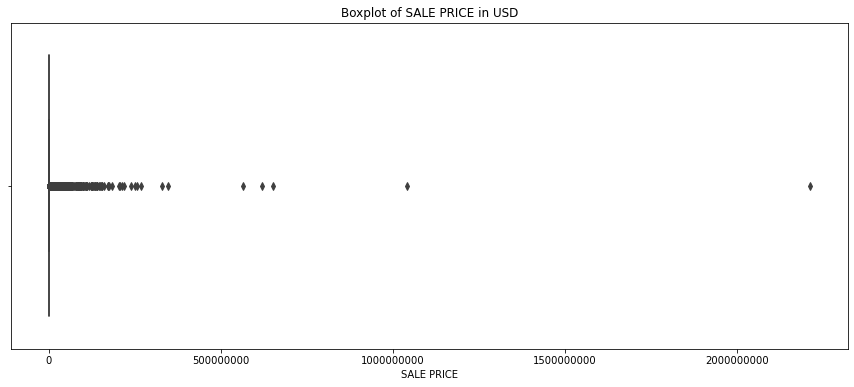

In [18]:
plt.figure(figsize=(15,6))

sns.boxplot(x='SALE PRICE', data=data)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

In [19]:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]


In [20]:
data['SALE PRICE'].skew()

2.3437455096169386

In [21]:
sales=np.log(data['SALE PRICE'])
print(sales.skew())

0.19896303705046872


In [22]:
data = data[data['GROSS SQUARE FEET'] < 10000]
data = data[data['LAND SQUARE FEET'] < 10000]

In [23]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24570
0,0,15489
2,2,9473
3,3,2720
4,4,695
6,6,360
5,5,170
8,8,133
7,7,70
9,9,56


In [24]:
data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)] 

In [25]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,38342,38342,38342,38342,38342,38342,38342,38342,38342
unique,5,247,36,9,104,30426,2642,3,104
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,131-05 40TH ROAD,,1,R4
freq,12599,1674,12215,23977,8918,209,26395,25206,8922


In [26]:
data['TAX CLASS AT PRESENT'].unique()

['2B', '2', '2A', '2C', '4', '1C', '1', '1A', '1B']
Categories (9, object): ['2B', '2', '2A', '2C', ..., '1C', '1', '1A', '1B']

In [27]:
pivot=data.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT PRESENT,
1,594000.0
1A,390000.0
1B,640606.5
1C,958668.0
2,980000.0
2A,1200000.0
2B,1847500.0
2C,835000.0
4,1050000.0


In [28]:
data['TAX CLASS AT TIME OF SALE'].unique()

[2, 4, 1]
Categories (3, int64): [2, 4, 1]

In [29]:
pivot=data.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
TAX CLASS AT TIME OF SALE,
1,582487.5
2,990000.0
4,1050000.0


In [30]:
data['BOROUGH'].unique()

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

In [31]:
pivot=data.pivot_table(index='BOROUGH', values='SALE PRICE', aggfunc=np.median)
pivot

,SALE PRICE
BOROUGH,
1,1435000.0
2,452750.0
3,860000.0
4,635000.0
5,470000.0


In [32]:
print(data['BUILDING CLASS CATEGORY'].nunique())

pivot=data.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

36


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,510000.0
02 TWO FAMILY DWELLINGS,664075.5
03 THREE FAMILY DWELLINGS,820000.0
04 TAX CLASS 1 CONDOS,420405.0
05 TAX CLASS 1 VACANT LAND,720000.0
06 TAX CLASS 1 - OTHER,500000.0
07 RENTALS - WALKUP APARTMENTS,1280000.0
08 RENTALS - ELEVATOR APARTMENTS,3670000.0
11A CONDO-RENTALS,999000.0


In [33]:
del data['ADDRESS']
del data['APARTMENT NUMBER']

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         38342 non-null  category
 1   NEIGHBORHOOD                    38342 non-null  object  
 2   BUILDING CLASS CATEGORY         38342 non-null  object  
 3   TAX CLASS AT PRESENT            38342 non-null  category
 4   BLOCK                           38342 non-null  int64   
 5   LOT                             38342 non-null  int64   
 6   BUILDING CLASS AT PRESENT       38342 non-null  object  
 7   ZIP CODE                        38342 non-null  int64   
 8   RESIDENTIAL UNITS               38342 non-null  int64   
 9   COMMERCIAL UNITS                38342 non-null  int64   
 10  TOTAL UNITS                     38342 non-null  int64   
 11  LAND SQUARE FEET                38342 non-null  float64 
 12  GROSS SQUARE FEET 

In [35]:
numeric_data.columns

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE'],
      dtype='object')

In [36]:
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])
scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

In [37]:
data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.552838,-0.871424,C4,-1.442057,4.726583,-0.204406,4.897089,-0.332369,3.247655,0.176451,2,C4,2.478171
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.545023,-0.654228,C4,-1.442057,4.109626,-0.204406,4.245205,-0.669316,1.421318,0.191071,2,C4,2.174164
76,1,ALPHABET CITY,12 CONDOS - WALKUP APARTMENTS,2,-1.584890,1.174680,R2,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,-3.818937,2,R2,-0.206132
79,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175214,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.094653
80,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.611925,1.175747,R4,-1.442057,-0.514625,-0.204406,-0.640828,0.691653,1.183694,0.191071,2,R4,0.113914


In [38]:
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

In [39]:
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38342 entries, 3 to 84545
Data columns (total 56 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   BOROUGH_1                                                             38342 non-null  uint8
 1   BOROUGH_2                                                             38342 non-null  uint8
 2   BOROUGH_3                                                             38342 non-null  uint8
 3   BOROUGH_4                                                             38342 non-null  uint8
 4   BOROUGH_5                                                             38342 non-null  uint8
 5   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       38342 non-null  uint8
 6   BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       38342 non-null  uint8
 7   BUILDING CLAS

In [40]:
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [41]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((38342, 65), (38342,))

In [42]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.33 , random_state =15)

In [43]:
X_train.shape , Y_train.shape

((25689, 65), (25689,))

In [44]:
X_test.shape , Y_test.shape

((12653, 65), (12653,))

In [45]:
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [46]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)

0.7514283711439866

In [47]:
alpha=0.00050
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)

0.7517699742161215

In [48]:
alpha=0.00050
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)

0.7517699742161215

In [49]:
ridge = Ridge(alpha=0.005, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)

0.7513317818716337

In [76]:
rf_regr = RandomForestRegressor(max_samples=0.4, max_depth=20)
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5477389619046104